## Introducción

En el presente trabajo se propone realizar un análisis de los datos recolectados por una empresa en los últimos 2 meses sobre los clientes que fueron a ver la pelicula Frozen 3. La encuesta consistía en una serie de preguntas personales que concluía si el cliente volvería a ese cine si salía la secuela, Frozen 4.

El objetivo de la empresa es poder dirigir futuras campañas de marketing digital en base a esta información recolectada.

## Objetivos

El objetivo de este notebook es:
*   Entender los datos
*   Ver cómo los datos se relacionan entre si
*   Poder sacar alguna conclusión o descubrir un patrón a partir de estos
*   Indicar cuáles son los factores más importantes que determinan si un usuario va a ir al cine a ver Frozen 4 o no.
*   Poder llegar a armar un baseline

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
from math import pi

## Carga y limpieza del set de datos

In [43]:
usuario_volveria_df = pd.read_csv(r'C:\Users\Enrique\Desktop\analisis\Analisis Exploratorio\Datasets\tp-2020-2c-train-cols1.csv')
usuario_volveria_df.head()

,id_usuario,volveria
0,117,0
1,658,0
2,794,0
3,455,0
4,173,1


In [44]:
info_fiumark_df = pd.read_csv(r'C:\Users\Enrique\Desktop\analisis\Analisis Exploratorio\Datasets\tp-2020-2c-train-cols2.csv')
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


### df volveria

In [45]:
usuario_volveria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id_usuario  801 non-null    int64
 1   volveria    801 non-null    int64
dtypes: int64(2)
memory usage: 12.6 KB


Notamos que la columna de 'volveria' es de tipo int64, cuando solamente tiene valores que pueden ser 0 o 1. Un mejor tipo de dato para este caso puede ser un int8. Esto permitiría ahorrar memoria. (Aunque en este caso no sean muchos datos)

In [46]:
usuario_volveria_df['volveria'] = usuario_volveria_df['volveria'].astype(np.int8)

Observamos que no tenemos valores nulos

In [47]:
usuario_volveria_df.isnull().sum()

id_usuario    0
volveria      0
dtype: int64

### info_fiumark_df

Notamos una gran cantidad de valores nulos en la columna "fila" y algunos en "edad" y "nombre_sede". Como las columnas que tienen los valores nulos pueden llegar a ser relevantes para el análisis, siendo este el caso de las columnas "fila" y "edad" decidimos crear la categoría "No responde" para el caso de "fila".

In [48]:
info_fiumark_df.isnull().sum()

tipo_de_sala       0
nombre             0
id_usuario         0
genero             0
edad             160
amigos             0
parientes          0
id_ticket          0
precio_ticket      0
fila             624
nombre_sede        2
dtype: int64

In [49]:
info_fiumark_df['fila'].fillna("No responde",inplace=True)

Ahora vemos la cantidad de valores únicos para las columnas de tipo objeto, para poder determinar a cuales les correspondería tener un tipo categórico.

In [50]:
info_fiumark_df.select_dtypes(include=['object']).nunique()

tipo_de_sala      3
nombre          801
genero            2
id_ticket       635
fila              3
nombre_sede       3
dtype: int64

In [51]:
info_fiumark_df["tipo_de_sala"] = info_fiumark_df["tipo_de_sala"].astype("category")
info_fiumark_df["genero"] = info_fiumark_df["genero"].astype("category")
info_fiumark_df["nombre_sede"] = info_fiumark_df["nombre_sede"].astype("category")
info_fiumark_df["fila"] = info_fiumark_df["fila"].astype("category")

Otra cosa que observamos es que las edades están en formato de float, lo cual nos resultó llamativo, por lo que decidimos cortar los valores, llevándolos al piso.

In [52]:
info_fiumark_df['edad'].value_counts()

27.00    28
22.00    25
25.00    25
31.00    23
21.00    23
         ..
77.00     1
27.50     1
3.67      1
58.50     1
26.50     1
Name: edad, Length: 84, dtype: int64

In [53]:
info_fiumark_df['edad'] = info_fiumark_df['edad'].apply(np.floor)

In [54]:
info_fiumark_df['edad'].value_counts()

27.0    29
22.0    25
25.0    25
31.0    24
33.0    24
        ..
62.0     1
83.0     1
15.0     1
69.0     1
66.0     1
Name: edad, Length: 71, dtype: int64

Pudimos observar que una parte en la columna de 'edad' tiene valores faltantes. Lo que decidimos hacer fue utilizar la columna 'nombre', que incluye sufijos como 'Señora' o 'Señorita' para rellenar el valor de edad.

Lo primero que hacemos es crear una nueva columna 'sufijo' a partir de los valores de nombres anteriores.

In [55]:
sufijos_y_nombres = info_fiumark_df.nombre.str.split(pat = ' ', n= 1,expand = True)
sufijos_y_nombres.columns = ['sufijo', 'nombre']

In [56]:
info_fiumark_df.drop('nombre', axis = 1, inplace = True)

In [57]:
info_fiumark_df = pd.concat([ sufijos_y_nombres, info_fiumark_df ], axis = 'columns')

In [58]:
info_fiumark_df.head()

,sufijo,nombre,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,Señor,Camilo Pedro,4d,117,hombre,73.0,0,0,59258;,1,No responde,fiumark_quilmes
1,Señora,Raquel Angelica,4d,658,mujer,35.0,1,1,586:6;,2,No responde,fiumark_quilmes
2,Señor,Antonio Federico,normal,794,hombre,NaN,0,0,"RE""39822",3,No responde,fiumark_chacarita
3,Señor,Osvaldo Aureliano,4d,455,hombre,NaN,0,0,"C17""4:39",1,No responde,fiumark_palermo
4,Señorita,Rita Eudosia,4d,173,mujer,4.0,1,1,569964,2,No responde,fiumark_palermo


Ahora reemplazamos la edad de las 'Señoras' que no contestaron la edad por la mediana de las que sí contestaron. Hacemos lo mismo para las 'Señoritas'.

Ademas creamos una columna 'autocompletamos_edad' para indicar cuáles de estas edades fueron completadas por nosotros.

In [59]:
mediana_edad_senioras = info_fiumark_df[info_fiumark_df['sufijo'] == 'Señora'].edad.dropna().median()
mediana_edad_senioritas = info_fiumark_df[info_fiumark_df['sufijo'] == 'Señorita'].edad.dropna().median()

In [60]:
info_fiumark_df['autocompletamos_edad'] = False

In [61]:
info_fiumark_df.loc[(info_fiumark_df['sufijo'] == 'Señora') & (info_fiumark_df['edad'].isnull()),'autocompletamos_edad'] = True
info_fiumark_df.loc[(info_fiumark_df['sufijo'] == 'Señorita') & (info_fiumark_df['edad'].isnull()),'autocompletamos_edad'] = True

In [62]:
info_fiumark_df['autocompletamos_edad'].value_counts()

False    755
True      46
Name: autocompletamos_edad, dtype: int64

In [63]:
info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señorita','edad'] = info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señorita','edad'].fillna(mediana_edad_senioritas)
info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señora','edad'] = info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señora','edad'].fillna(mediana_edad_senioras) 

Veamos ahora el caso de los hombres. Algo que notamos en este caso, es que no tenemos el sufijo 'Señorito' como para tener una distinción muy marcada en comparación a la de las mujeres. Pero observando que la cantidad de niños que respondieron la encuesta es mucho menor en proporción a la de los hombres, decidimos realizar el reemplazo tomando también la mediana.

In [64]:
def cantidad_total_de_ninios(edad):
    ninios = edad<=10
    return ninios.sum()

info_fiumark_df.groupby(by='genero').agg({'edad':cantidad_total_de_ninios}).rename(columns={'edad':'Cantidad de ninios que respondieron la encuesta'})

In [65]:
mediana_edad_senior = info_fiumark_df[info_fiumark_df['sufijo'] == 'Señor'].edad.dropna().median()

In [66]:
info_fiumark_df.loc[(info_fiumark_df['sufijo'] == 'Señor') & (info_fiumark_df['edad'].isnull()),'autocompletamos_edad'] = True
info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señor','edad'] = info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señor','edad'].fillna(mediana_edad_senior)

También observamos que entre los datos que nos fueron entregados se encuentra el código de ticket: "id_ticket". Consideramos que la información en ella es irrelevante para nuestros propósitos y por lo tanto la eliminamos. Esta decisión se debe a que parece que el código del ticket tiene forma de ser generada de forma aleatoria y no da la impresión de estar relacionada con la variable de interés (si volvería) para el análisis.

In [67]:
info_fiumark_df.drop(columns='id_ticket',inplace=True)

Ahora revisamos que la columna nombre tenga efectivamente nombres. Por ejemplo, esta columna no puede tener numeros.

In [68]:
info_fiumark_df['nombre'].str.contains('1|2|3|4|5|6|7|8|9|0|#|%|&|!|@').any()

False

Vemos que la columna 'nombre' esta compuesta por caracteres validos.

Habiendo hecho esos cambios, finalmente nos queda el dataframe de la siguiente forma. En el proceso se redujo el uso de memoria, pasando de 69.0KB a 48.2KB.

In [69]:
info_fiumark_df.head()

,sufijo,nombre,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,autocompletamos_edad
0,Señor,Camilo Pedro,4d,117,hombre,73.0,0,0,1,No responde,fiumark_quilmes,False
1,Señora,Raquel Angelica,4d,658,mujer,35.0,1,1,2,No responde,fiumark_quilmes,False
2,Señor,Antonio Federico,normal,794,hombre,32.0,0,0,3,No responde,fiumark_chacarita,True
3,Señor,Osvaldo Aureliano,4d,455,hombre,32.0,0,0,1,No responde,fiumark_palermo,True
4,Señorita,Rita Eudosia,4d,173,mujer,4.0,1,1,2,No responde,fiumark_palermo,False


Ahora dejamos unidos ambos dataframes.

In [71]:
info_fiumark_df = info_fiumark_df.merge(usuario_volveria_df,on='id_usuario')

Por último, sacamos la columna de 'id_usuario', ya que no es necesaria para el análisis.

In [72]:
info_fiumark_df.drop(columns='id_usuario',inplace=True)
info_fiumark_df.head()

,sufijo,nombre,tipo_de_sala,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,autocompletamos_edad,volveria
0,Señor,Camilo Pedro,4d,hombre,73.0,0,0,1,No responde,fiumark_quilmes,False,0
1,Señora,Raquel Angelica,4d,mujer,35.0,1,1,2,No responde,fiumark_quilmes,False,0
2,Señor,Antonio Federico,normal,hombre,32.0,0,0,3,No responde,fiumark_chacarita,True,0
3,Señor,Osvaldo Aureliano,4d,hombre,32.0,0,0,1,No responde,fiumark_palermo,True,0
4,Señorita,Rita Eudosia,4d,mujer,4.0,1,1,2,No responde,fiumark_palermo,False,1


## Análisis exploratorio

Empecemos el análisis haciendonos algunas preguntas sencillas, y en cada caso si es que surge alguna nueva pregunta interesante se continuara su desarrollo en esa sección.  
* ¿Es el género una variable determinante a la hora de decidir ver la secuela?
* ¿Como es la relación con la edad?
* ¿Afecta en la decisión de volver el ir a ditintos tipos de sala?
* ¿Hay mas gente que iría a la secuela si fue a una sede en particular?
* ¿El precio fue determinante?
* ¿La ubicación en la sala importa?


### ¿Cuánto afecta el género a la hora de ir a ver la siguiente pelicula?

plt.figure(figsize=(6.4, 4.8), dpi=100)
genero = info_fiumark_df['genero'].value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%')Veamos primero que proporción de las personas que fueron a ver la película son hombres y que proporción mujeres:

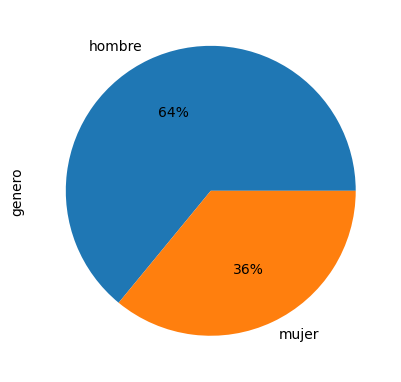

In [155]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
genero = info_fiumark_df['genero'].value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%')

Observamos que casi dos tercios de las personas que fueron a ver la pelicula son hombres y un tercio mujeres.
Si bien a primera vista esto parece indicar que la película atrae más a hombres que a mujeres, esto también deberse a que simplemente mas hombres respondieron la encuesta.

Buscamos ver ahora que proporción de los hombres y mujeres que fueron a ver la película volverían a ver la secuela. Esto se puede obtener de forma sencilla.

A priori esperamos que la proporción de mujeres que deciden ir a ver la secuela sea mucho mayor que la de los hombres.

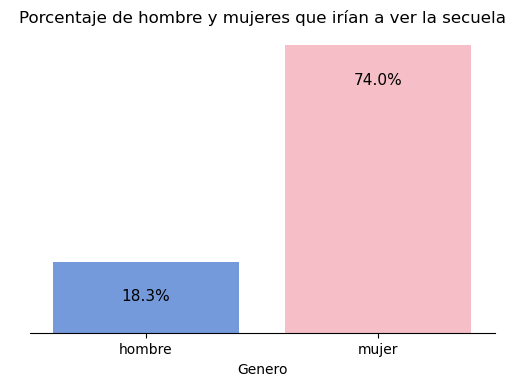

In [163]:
plt.figure(dpi=100)

df= pd.DataFrame(info_fiumark_df.groupby(by='genero')['volveria'].agg('mean').reset_index())
sns.barplot(x=df.genero, y=df.volveria.round(3), palette = ['cornflowerblue','lightpink'])

for i, g in enumerate(df.volveria.round(3)):
    plt.text(i, g-0.1,"{}%".format(g*100), ha='center', fontsize=11)
    
plt.xlabel('Genero')
plt.ylabel(" ")
plt.yticks([])
plt.title('Porcentaje de hombre y mujeres que irían a ver la secuela')

sns.despine(left=True)

Habiendo hecho el cálculo, en los números se ve claramente lo esperado.

El gráfico de barras anterior nos muestra que del total de mujeres que fue a ver la película un 74% de ellas volvería a ver la secuela. Mientras que solo el 18% de los hombres disfrutó la película lo suficiente como para querer ir a ver la secuela. Como conclusión a la pregunta, esto parece indicar que el género es una variable muy importante.

#### ¿Por qué tenemos mayor proporción de hombres encuestados?

Habiendo observado el primer gráfico de tortas, notamos que una mayor cantidad de hombres que de mujeres respondieron la encuesta, por lo que nos surgió esta pregunta. Nuestra hipótesis es que pueden ser padres que llevaron a sus hijos a ver la película.

Para responder esta pregunta y evaluar nuestra hipótesis, buscamos primero ver la distribución de las edades de los hombres y las mujeres, para ello realizamos un boxplot.

In [ ]:
plt.figure(dpi=150)

plt.title("Edades por género")
sns.boxplot(
    data= info_fiumark_df.loc[~info_fiumark_df['autocompletamos_edad'],['genero','edad']],
    y='edad',
    x='genero',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Edad")
plt.xlabel("Género")
plt.xticks([False, True])
plt.show()

Podemos ver que la edad mediana de los hombres que fueron a ver la película es ligeramente mayor que la de las mujeres. Seguimos investigando con respecto a si llevaron parientes, para seguir evaluando nuestra hipótesis.

In [ ]:
mayor_a_treinta = info_fiumark_df['edad'] >= 30
con_pariente = info_fiumark_df['parientes'] >= 1
es_hombre = info_fiumark_df['genero'].str.contains('hombre')

In [ ]:
info_fiumark_df.loc[mayor_a_treinta & con_pariente & es_hombre,'nombre'].count()

In [ ]:
info_fiumark_df.loc[mayor_a_treinta & (~con_pariente) & es_hombre,'nombre'].count()

Vemos que la cantidad de casos hombres mayores a 30 años, que fueron encuestados y fueron sin parientes es mucho mayor a la de los que suponemos que deben ser padres (los que fueron con parientes) por lo que descartamos la hipótesis.

Respondemos la pregunta que nos habíamos planteado diciendo que es probable que tengamos mayor cantidad de hombres encuestados simplemente porque los hombres fueron más propensos a completar la encuesta que las mujeres.

### ¿Cómo es la relación con la edad?

Busquemos ahora como se distribuye la edad de las personas que respondieron la encuesta.

In [ ]:
edades_sin_completar = info_fiumark_df.loc[~info_fiumark_df['autocompletamos_edad'],'edad']

In [ ]:
sns.set(rc={'figure.figsize':(8,7)})
plt.figure(dpi=100)
g=sns.distplot( a=edades_sin_completar,
             hist=True, kde=False, rug=False,
             bins=40,
             axlabel='Edad',
             color='goldenrod')
g.set_title('Distribucion de la edad de quienes respondieron la encuesta')
g.set_ylabel("Cantidad de personas")

plt.show()

Vemos que la gran mayoría de los que respondieron la encuesta está en el rango de entre 20 y 50 años de edad. Mostramos ahora su relación con volver a la secuela.

In [ ]:

edades_cortadas = pd.cut(info_fiumark_df['edad'], bins = 10)

ax = info_fiumark_df.groupby(edades_cortadas)['volveria'].mean().plot(kind='bar',rot=0,figsize=(15,6),color='sandybrown',
                                                                 title='Relación entre las edades y volver a ver la secuela')

ax.set_ylabel("Porcentaje de vuelta")
ax.set_ylim(0,1)

Si bien el gráfico anterior nos permite ver que los niños vuelven más a ver la secuela, no nos aporta demasiada información para el resto de los rangos etáreos. Notar que la barra de (27,35] está algo más abajo que las demás, esto se debe a que se están tomando las edades completadas (las que completamos con medianas) en este gráfico. Sin ellas, esta barra estaría en el orden de las vecinas. Seguimos investigando sobre la edad tratando de relacionarla con el género.

#### Cruzamos el género con la edad

Intentemos relacionar ahora la edad de las personas y su género con si volverían o no a ver la película. Para eso 
agrupamos en hombres y mujeres y luego estos grupos por edad:

In [ ]:
edad =  info_fiumark_df['edad']
genero = info_fiumark_df['genero']
volveria = info_fiumark_df['volveria']

hombres_vuelven = info_fiumark_df.loc[genero.str.contains('hombre') & (volveria == 1)]
hombres_total = info_fiumark_df.loc[genero.str.contains('hombre')]

mujeres_vuelven = info_fiumark_df.loc[genero.str.contains('mujer') & (volveria == 1)]
mujeres_total = info_fiumark_df.loc[genero.str.contains('mujer')]

In [ ]:
rango_edades = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

cuts_total_mujeres = pd.cut(mujeres_total['edad'], bins = rango_edades)
cuts_vuelven_mujeres = pd.cut(mujeres_vuelven['edad'], bins = rango_edades)

cuts_total_hombres = pd.cut(hombres_total['edad'], bins = rango_edades)
cuts_vuelven_hombres = pd.cut(hombres_vuelven['edad'], bins = rango_edades)

In [ ]:
serie_hombres = pd.Series(cuts_vuelven_hombres.value_counts()/cuts_total_hombres.value_counts())
serie_mujeres = pd.Series(cuts_vuelven_mujeres.value_counts()/cuts_total_mujeres.value_counts())

In [ ]:
plt.figure(dpi=100)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=130, figsize=(13, 4.8))

axes[0].bar(serie_hombres.index.astype(str), serie_hombres.values, color = 'blue', alpha = 0.5)

axes[0].set_title("Distribución por edades de hombres que volverían")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Porcentaje que volveria")
axes[0].tick_params('x',labelrotation=35)

axes[1].bar(serie_mujeres.index.astype(str), serie_mujeres.values, color = 'coral', alpha = 0.5)

axes[1].set_title("Distribución por edades de mujeres que volverían")
axes[1].set_xlabel("Edad")
axes[1].set_ylabel("Porcentaje que volvería")


plt.show()

Se puede ver claramente que a los hombres de edades entre 0 y 10 les gusto mucho más que al resto de los hombres.
Por otro lado el porcentaje de mujeres que volverían a ver la pelicula es mayor que el de hombres para todos los rangos de edades y parece ir ligeramente aumentando con la edad.

Notamos también la barra de los hombres de entre (80,90], habiendo visto la distribución de edades puesta en el histograma mas arriba, este es un único caso, por lo que no representa algo significativo.

Concluimos viendo lo anterior que hay una fuerte relación entre el género y la edad. Seguimos con otras preguntas que surgieron a partir de esta.

#### ¿Estarán relacionadas la edad y los parientes?

Para responder esta pregunta creamos una clasificación de las edades de forma más categórica, de forma tal de poder observar mejor los datos.

In [ ]:
def estratificar_edades(edad):
    if(edad <= 10):
        return 'ninio'
    elif(edad <=25):
        return 'joven'
    elif(edad <= 50):
        return 'adulto'
    return 'mayor'

In [ ]:
info_fiumark_df['edades_estratificadas'] = info_fiumark_df['edad'].apply(estratificar_edades)

In [ ]:
sns.set(rc={'figure.figsize':(8,7)})
parientes_edad = pd.pivot_table(data = info_fiumark_df, index = 'parientes', values = 'volveria', columns = 'edades_estratificadas')
parientes_edad.sort_index(ascending =  False, inplace = True)
parientes_edad = parientes_edad.reindex( ['ninio', 'joven' ,'adulto', 'mayor'],axis = 1)

mascara = parientes_edad.isnull()
g = sns.heatmap(parientes_edad, mask = mascara, cmap="YlGnBu", annot=True)
g.set_ylabel("Cantidad de parientes")
g.set_xlabel("Edad")
g.set_title("Porcentaje que volvería según edad y parientes")

plt.show()

En el gráfico anterior podemos ver cómo se se relacionan los parientes y la edad con su decisión de volver al cine. Observamos que los niños son los que mas volverían. Además los niños parecen volver con mayor probabilidad si fueron con menos parientes. 

En el heatmap parecería que un 100% de los niños que fueron sin parientes volvería a ver la secuela. Lo mismo observamos para los adultos que fueron acompañados por exactamente 3 parientes. Esto nos lleva a querer saber cuántas personas en estas categorías efectivamente volverían para saber si son una cantidad representativa.

In [ ]:
info_fiumark_df.loc[(info_fiumark_df['edades_estratificadas'] == 'ninio')  & (info_fiumark_df['parientes'] == 0),'nombre'].count()

Observamos que solo un niño no fue con parientes y fue encuestado por lo que consideramos que esto no es una muestra representativa. Veamos ahora el caso de los adultos que fueron con 3 parientes.

In [ ]:
info_fiumark_df.loc[(info_fiumark_df['edades_estratificadas'] == 'adulto')  & (info_fiumark_df['parientes'] == 3), 'nombre'].count()

Lo mismo que sucede en el caso anterior. Solo tenemos 2 personas que cumplen estas condiciones por lo que no nos 
parece suficiente para sacar alguna conclusión de estas.

#### Niños y parientes

Una cosa que nos permitió ver el heatmap anterior, es ver que los niños de entre 0 y 10 años van acompañados por un adulto, algo que es esperable. Además los niños que fueron acompañados por exactamente 1 adulto parecería que disfrutaron más la película que los que fueron acopañados por 2. Vemos cuan valida sería esta afirmación viendo la cantidad de casos que tenemos cumpliendo esto.

In [ ]:
menor_10_anios = info_fiumark_df['edad'] <= 10
un_pariente = info_fiumark_df['parientes'] == 1
dos_parientes = info_fiumark_df['parientes'] == 2
vuelve = info_fiumark_df['volveria'] == 1


In [ ]:
cant_ninio_un_pariente_total = info_fiumark_df.loc[menor_10_anios & un_pariente,'nombre'].count() # Nos quedamos con cualquier fila, solo nos interesa saber cuantos son
cant_ninio_un_pariente_vuelve = info_fiumark_df.loc[menor_10_anios & un_pariente & vuelve,'nombre'].count()
cant_ninio_dos_pariente_total = info_fiumark_df.loc[menor_10_anios & dos_parientes,'nombre'].count()
cant_ninio_dos_pariente_vuelve = info_fiumark_df.loc[menor_10_anios & dos_parientes & vuelve,'nombre'].count()

In [ ]:
print("Menores a 10, con un pariente: ",cant_ninio_un_pariente_total)
print("Menores a 10, con un pariente que vuelven: ",cant_ninio_un_pariente_vuelve)
print("Menores a 10, con dos pariente: ",cant_ninio_dos_pariente_total)
print("Menores a 10, con dos pariente que vuelven: ",cant_ninio_dos_pariente_vuelve)

Observamos que son pocos casos como para considerar que es algo muy determinante, sin embargo se ve que lo propuesto inicialmente con respecto a los niños se cumple.

#### ¿La edad con la cantidad de amigos tendrán alguna relación?

Usamos la misma estratificación que antes, solo que viendo los amigos en este caso.

In [ ]:
sns.set(rc={'figure.figsize':(8,7)})
amigos_edad = pd.pivot_table(data = info_fiumark_df, index = 'amigos', values = 'volveria', columns = 'edades_estratificadas')
amigos_edad.sort_index(ascending =  False, inplace = True)
amigos_edad = amigos_edad.reindex( ['ninio', 'joven' ,'adulto', 'mayor'],axis = 1)

In [ ]:
mascara = amigos_edad.isnull()
g = sns.heatmap(amigos_edad, mask = mascara, cmap="YlGnBu",annot=True)

g.set_title("Porcentaje que volvería según edad y amigos")
g.set_ylabel("Cantidad de amigos")
g.set_xlabel("Edad")

plt.show()

En este heatmap podemos ver que los jovenes tienden a disfrutar la pelicula si fueron con
hasta 2 amigos. Si fueron con 3 amigos o más tienden a no querer volver a ver la secuela. Se puede ver algo muy similar también con el caso de los niños, donde casi todos deciden volver.

Buscamos de cuantos casos estamos hablando en los jóvenes y niños.

In [ ]:
fue_con_varios_amigos = info_fiumark_df['amigos']>=3
volveria =  info_fiumark_df['volveria']==1
es_joven = info_fiumark_df['edad']<=25

In [ ]:
info_fiumark_df.loc[(~fue_con_varios_amigos) & es_joven]['nombre'].count()

In [ ]:
info_fiumark_df.loc[(~fue_con_varios_amigos) & es_joven & volveria]['nombre'].count()

Ahora veamos cuántos jóvenes y niños fueron con varios amigos.

In [ ]:
info_fiumark_df.loc[fue_con_varios_amigos]['nombre'].count()

In [ ]:
info_fiumark_df.loc[fue_con_varios_amigos & volveria]['nombre'].count()

Vemos que lo observado es correcto, los jóvenes y niños que fueron con menos de tres amigos, son mucho más probables a volver que en el caso contrario.

#### Veamos la cantidad total de invitados y edad

Estudiando las relaciones de edad-amigos y edad-parientes de los encuestados nos surgió la idea de estudiar la relación edad-invitados donde invitados es la suma de los amigos y los parientes con los que cada encuestado fue a ver la película.


In [ ]:
info_fiumark_df['invitados_totales'] = info_fiumark_df['amigos'] + info_fiumark_df['parientes'] 

In [ ]:
sns.set(rc={'figure.figsize':(8,7)})
amigos_edad = pd.pivot_table(data = info_fiumark_df, index = 'invitados_totales', values = 'volveria', columns = 'edades_estratificadas', aggfunc = 'mean')

amigos_edad
amigos_edad.sort_index(ascending =  False, inplace = True)
amigos_edad = amigos_edad.reindex( ['ninio', 'joven' ,'adulto', 'mayor'],axis = 1)

mascara = amigos_edad.isnull()
g = sns.heatmap(amigos_edad, mask = mascara, cmap="YlGnBu", annot = True)

g.set_title("Porcentaje que volvería según edad e invitados")
g.set_ylabel("Cantidad de invitados")
g.set_xlabel("Edad")

No pudimos ver diferencias apreciables con los gráficos que obtuvimos por separado para amigos-edad y parientes-edad. Observamos que se repite la tendencia ya mencionada sobre los niños y jóvenes. 

Tambien notamos que los encuestados que fueron con 1, 2 ó 3 invitados, son los que tienen mayores probabilidades de volver. Que los encuestados con mayor cantidad de invitados tiendan a no volver no debe de ser casualidad, puede deberse a que la salida en grupo es más para estar juntos y no tanto como para ver la película en si.

In [ ]:
entre_uno_tres_invitados = info_fiumark_df.loc[(info_fiumark_df['invitados_totales']>=1) & (info_fiumark_df['invitados_totales']<=3),'nombre'].count()
entre_uno_tres_invitados_vuelta = info_fiumark_df.loc[(info_fiumark_df['invitados_totales']>=1) & (info_fiumark_df['invitados_totales']<=3) & volveria,'nombre'].count()
(entre_uno_tres_invitados_vuelta/entre_uno_tres_invitados).round(2)

Vemos que casi un 60% de los encuestados vuelve al considerar ese rango de invitados.

La categoría de 'mayor', observamos que tiene números altos también para 1 y 3 invitados, sin embargo son pocos casos (tan solo 18) para considerarlos por sí solos.

In [ ]:
info_fiumark_df.loc[((info_fiumark_df['invitados_totales']==1) | (info_fiumark_df['invitados_totales']==3)) & (info_fiumark_df['edad']>50),'nombre'].count()

### ¿Afecta en la decisión de volver el haber ido a un tipo de sala puntual?

Veamos ahora si la decisión de ir a un mejor tipo de sala determina si se vuelve a ver la secuela. 

Para empezar veamos cuales hay.

In [ ]:
cantidad_salas = info_fiumark_df['tipo_de_sala'].value_counts()
cantidad_salas

Sorprendentemente, la mayoría de la gente que respondió la encuesta fue a ver la pelicula a las salas especiales (4D y 3D). Esto se puede deber a que se busca tener una experiencia única al momento de ir al cine. Esto lo mostramos en el siguiente gráfico con respecto a la cantidad total de gente que fue.

In [ ]:
circulo_centro=plt.Circle( (0,0), 0.7, color='white')
plt.figure(dpi=80)
plt.pie(cantidad_salas.values, labels=cantidad_salas.index.to_list(), colors=['goldenrod','salmon','skyblue'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(circulo_centro)
plt.suptitle('Proporción de a qué sala fue la gente que respondió la encuesta')
plt.show()

Busquemos ahora si hay relación con ir a ver la secuela.


In [ ]:
porcentaje_volveria_salas = info_fiumark_df.groupby(by='tipo_de_sala')['volveria'].agg('mean').round(2)
porcentaje_volveria_salas

In [ ]:
porcentaje_volveria_salas.sort_values(ascending=False,inplace=True)
plt.figure(dpi=100)
plt.bar(porcentaje_volveria_salas.index, porcentaje_volveria_salas.values, color = ['darksalmon','lightgreen','lightskyblue'])
plt.ylabel("Porcentaje")
plt.xlabel("Tipos de sala de cine")
plt.ylim(0, 1)
plt.title('Porcentaje de personas que irían a ver la secuela por sala')
plt.show()

Observando los resultados, notamos que una gran cantidad de la gente que fue a la sala 4D, decidió que no volvería a ver la secuela (cercano al 80%). Uno de los motivos por los que esto puede llegar a ser es que las personas que deciden ir a esta sala esperan tener una gran experiencia debido a los efectos que agrega la sala, ya sean movimientos, niebla, lluvia, u otros efectos del estilo, los cuales pueden no estar siendo aprovechados del todo durante la proyección de la película.


Con respecto a la sala 3D, podemos decir que no nos estaría aportando mucho por si sola. Esto se debe a que la mitad de la gente que decide ir a esta sala volvería a la secuela, mientras que el resto no. Resultando como si fuera el lanzamiento de una moneda.

Por último, de la sala normal podemos decir que cerca del 64% dijo que volvería a la secuela. Que una mayor cantidad diga en esta sala que volvería puede deberse a que ya conocieran de antes la serie de películas Frozen.

Veamos si podemos obtener algun refinamiento de estos datos cruzandola con la variable 'genero'.

#### Cruzamos el tipo de sala con el género

In [ ]:
porcentaje_sala_sexo = info_fiumark_df.groupby(by=['tipo_de_sala','genero'])['volveria'].agg('mean').round(2).unstack().T
porcentaje_sala_sexo = porcentaje_sala_sexo.mul(100)
porcentaje_sala_sexo

Vemos que las mujeres son mas probables a responder que volverían en todos los casos, estando en valores mayores al 90% para las salas normal y 3D. 

Algo a notar con respecto a los hombres es que parecen querer volver algo más si es que fueron a la sala normal en comparación con el resto.

In [ ]:
# -------Creamos el fondo
categorias=list(porcentaje_sala_sexo)[0:]
cantidad_categorias = len(categorias)
 
# Armamos el angulo de cada eje
angulos = [n / float(cantidad_categorias) * 2 * pi for n in range(cantidad_categorias)]
angulos += angulos[:1]
 
# Inicializamos el plot
ax = plt.subplot(111, polar=True)
 
# El primer eje esta arriba
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Dibujamos los ejes y los nombres
plt.xticks(angulos[:-1], categorias)

# Etiquetas en el eje y
ax.set_rlabel_position(0)
plt.ylim(0,100)

# Primer grupo
values1=porcentaje_sala_sexo.iloc[0].values.tolist()
values1 += values1[:1]
ax.plot(angulos, values1, linewidth=1, linestyle='solid', label="Hombre")
ax.fill(angulos, values1, 'b', alpha=0.1)

# Segundo grupo
values2=porcentaje_sala_sexo.iloc[1].values.tolist()
values2 += values2[:1]
ax.plot(angulos, values2, linewidth=1, linestyle='solid', label="Mujer")
ax.fill(angulos, values2, 'g', alpha=0.1)
##
plt.suptitle('Porcentaje que volvería de acuerdo a la sala por genero')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

Algo curioso que se nota al observar el gráfico, es que parece como si el caso de los hombres siguiera el mismo estilo que el de las mujeres, solo que con un tamaño menor.

En conclusión, las salas a las que fue cada persona parece ser un factor relevante para determinar si va a la secuela.

### ¿Hay más gente que iría a ver la secuela si fue a una sede en particular?

En esta sección buscamos saber si por algún motivo alguna sede en particular ayuda a influenciar la ida a la secuela. Los mótivos por los que esto podría llegar a suceder pueden estar relacionados a la calidad del cine, esto puede comprender tanto personal, calidad de las butacas, variedad de la tienda de snacks, etc.

Empecemos viendo cuántas sedes tenemos y como se distribuyó la cantidad de gente que fue a cada una. De ahí veremos si surge que los encuestados de alguna sede prefieren ir a ver la secuela mas que los encuestados de otra.

In [ ]:
cantidad_sedes = info_fiumark_df['nombre_sede'].value_counts(normalize=True).round(2)
cantidad_sedes

In [ ]:
circulo_centro=plt.Circle( (0,0), 0.7, color='white')
plt.figure(dpi=80)
plt.pie(cantidad_sedes.values, labels=cantidad_sedes.index.to_list(), colors=['goldenrod','salmon','skyblue'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(circulo_centro)
plt.suptitle('Proporción de a que cine corresponden los encuestados')
plt.show()

Observando lo obtenido, notamos que tenemos 3 sedes y que la mayoría de los encuestados corresponden a la sede de Fiumark en Palermo. Veamos ahora la vuelta a la secuela para cada sede en particular.

In [ ]:
info_fiumark_df.groupby(by='nombre_sede').agg({'volveria':'mean'}).round(2)

In [ ]:
volveria_por_sede = info_fiumark_df.groupby(by="nombre_sede")['volveria'].value_counts(normalize=True)
volveria_por_sede_df = volveria_por_sede.to_frame()
volveria_por_sede_df.rename(columns={'volveria':'Cantidad de respuestas'},inplace=True)
volveria_por_sede_df.reset_index(inplace=True)
volveria_por_sede_df.rename(columns={'volveria':'Vuelve a la secuela','nombre_sede':'Sedes'},inplace=True)

In [ ]:
volveria_por_sede_df['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

In [ ]:
g = sns.catplot(
    data=volveria_por_sede_df, kind="bar",
    x="Sedes", y="Cantidad de respuestas", hue="Vuelve a la secuela",
    ci=None, palette="colorblind", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de vuelta por sede")
g.despine(left=True)
plt.ylim(0,1)
g.set_axis_labels("Sede", "Porcentaje")

Al ver cuantos volverían por sede, obtenemos que la sede no parece ser tan determinante por si sola, quizas podemos notar que en la de Palermo parece que se tiende a no volver, pero hay que tener en cuenta que esta es la que acumula mayor cantidad de encuestados.

#### ¿Estarán relacionados el género y la sede?

En este punto nos interesa ver si hay alguna relación en este caso. Quizás para los hombres o mujeres, no les gustó determinado aspecto del cine.

In [ ]:
sede_genero = info_fiumark_df.groupby(by=["nombre_sede","genero"]).agg({'volveria':'mean'})
sede_genero = sede_genero.unstack('nombre_sede').round(2)
sede_genero.columns = sede_genero.columns.get_level_values(1)
sede_genero

Para concluir esta pregunta que surgió, no parece que haya una relación, ya que parece que independientemente de la sede, las mujeres volverían mucho más que los hombres para todos los casos. Esto sigue la misma línea de lo ya observado antes.

### ¿El precio fue determinante?

Veamos primero como se distribuyen los precios, y después la relación con respecto a la variable de interés.

In [ ]:
sns.set(rc={'figure.figsize':(8,7)})
plt.figure(dpi=100)
g=sns.distplot( a=info_fiumark_df['precio_ticket'],
             hist=True, kde=False, rug=False,
             bins=40,
             axlabel='Precio del ticket')
g.set_title('Distribución del precio del ticket')
g.set_ylabel("Cantidad de personas")

plt.show()

Podemos observar que la mayoría de los que fueron a ver la película pago precios inferiores a $\$$10, con algunos casos excepcionales que pagaron alrededor de $\$$50. Veamos la relación ahora, para ello creamos categorías en las cuales al comienzo son mas específicas debido a la cantidad de casos, y hacia el final creamos una que agrupe todas.

In [ ]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
rango_precios = pd.cut(info_fiumark_df['precio_ticket'], bins=bins)

volveria_por_rango_precio = info_fiumark_df.groupby(by=rango_precios)['volveria'].value_counts()
volveria_por_rango_precio_df = volveria_por_rango_precio.to_frame()
volveria_por_rango_precio_df.rename(columns={'volveria':'Cantidad de respuestas'},inplace=True)
volveria_por_rango_precio_df.reset_index(inplace=True)
volveria_por_rango_precio_df.rename(columns={'volveria':'Vuelve a la secuela','precio_ticket':'Rango de precios'},inplace=True)

In [ ]:
volveria_por_rango_precio_df['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

In [ ]:
g = sns.catplot(
    data=volveria_por_rango_precio_df, kind="bar",
    x="Rango de precios", y="Cantidad de respuestas", hue="Vuelve a la secuela",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Cantidad de respuestas de vuelta")
g.despine(left=True)
g.set_axis_labels("Rango de precios", "Cantidad de respuestas")

Veamos ahora normalizado que obtenemos.

In [ ]:
volveria_por_rango_precio = info_fiumark_df.groupby(by=rango_precios)['volveria'].value_counts(normalize=True)
volveria_por_rango_precio_df = volveria_por_rango_precio.to_frame()
volveria_por_rango_precio_df.rename(columns={'volveria':'Cantidad de respuestas'},inplace=True)
volveria_por_rango_precio_df.reset_index(inplace=True)
volveria_por_rango_precio_df.rename(columns={'volveria':'Vuelve a la secuela','precio_ticket':'Rango de precios'},inplace=True)
volveria_por_rango_precio_df['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=volveria_por_rango_precio_df, kind="bar",
    x="Rango de precios", y="Cantidad de respuestas", hue="Vuelve a la secuela",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Respuestas de vuelta normalizado")
g.despine(left=True)
g.set_axis_labels("Rango de precios", "Porcentaje de la respuesta")

Lo que nos encontramos es que en el rango más bajo (de 0 a 1) la mayoría respondió que no volvería, mientras que a partir de que se empieza a incrementar el precio aumenta la cantidad de gente que responde que vuelve. Una hipótesis respecto a esto puede ser que la gente que gasto mas se convence que el gasto realizado valió la pena, de forma tal de que se van con una mejor opinión respecto a la película y una potencial secuela. También hay que tener en cuenta que se obtuvo una mayor cantidad de respuestas de los rangos mas bajos, por lo que sus resultados son más representativos que los últimos.

#### ¿Habrá alguna relación entre el precio y la edad?

Vemos ahora como se distribuye la edad de los encuestados con respecto al precio, ya que puede surgir el caso de que a partir de cierto rango de edades se pague mas o menos.

In [ ]:
#Sacamos los valores que estarian muy lejos, debido a que arruinan la escala.
precio_menor_a_treinta = info_fiumark_df.loc[info_fiumark_df["precio_ticket"]<30]
precio_menor_a_treinta = precio_menor_a_treinta.rename(columns={'volveria':'Vuelve a la secuela','precio_ticket':'Precios','edad':'Edad'})
precio_menor_a_treinta['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

In [ ]:

sns.lmplot( x='Edad', y='Precios',data=precio_menor_a_treinta,fit_reg=False, hue='Vuelve a la secuela', legend=True,height=7,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Precio/Edad vuelta a la secuela, sin discriminar genero")
plt.show()

Buscamos con los géneros separados ahora.

In [ ]:
precio_menor_a_treinta_hombre = precio_menor_a_treinta.loc[precio_menor_a_treinta['genero'].str.contains('hombre')]
precio_menor_a_treinta_mujer = precio_menor_a_treinta.loc[precio_menor_a_treinta['genero'].str.contains('mujer')]

In [ ]:
sns.lmplot( x='Edad', y='Precios',data=precio_menor_a_treinta_hombre,fit_reg=False, hue='Vuelve a la secuela', legend=True,height=8,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Precio/Edad vuelta a la secuela, solo hombres")
plt.show()

In [ ]:
sns.lmplot( x='Edad', y='Precios',data=precio_menor_a_treinta_mujer,fit_reg=False, hue='Vuelve a la secuela', legend=True,height=8,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Precio/Edad vuelta a la secuela, solo mujeres")
plt.show()

Observando todos los gráficos hechos, notamos que el primer gráfico no se podía apreciar demasiado al tener ambos géneros juntos, pero al separarlos por edad se puede ver claramente la diferencia. Respecto a los hombres, la gran mayoría dice no volver, independientemente de la edad y del precio, y para el caso de las mujeres sucede lo contrario, estas volverían independientemente también de la edad y del precio. No se observan zonas donde se agrupen de forma particular los encuestados que volverían.

### ¿Importa la ubicación en la sala?

Veamos ahora si podemos llegar a sacar alguna conclusión interesante sobre las filas. Lo primero que debemos de tener en cuenta antes de comenzar, es que este atributo tiene en su gran mayoría valores nulos que fueron remplazados por 'No responde'. Vemos las cantidades con las que vamos a estar trabajando.

In [ ]:
info_fiumark_df['fila'].value_counts()

Notamos que tenemos muy pocos casos que respondieron 'medio', por lo que no vamos a poder sacar algo representativo de esas respuestas.

Buscamos la proporción de gente que vuelve por ubicación.

In [ ]:
vuelta_por_fila = info_fiumark_df.groupby(by='fila').agg({'volveria':'mean'}).round(2)
vuelta_por_fila

In [ ]:
vuelta_por_fila.sort_values(by='volveria',ascending=False,inplace=True)
plt.bar(vuelta_por_fila.index.astype(str), vuelta_por_fila['volveria'], color = 'olive', alpha = 0.6)
plt.title("Porcentaje de vuelta por lugar en donde se sentó")
plt.xlabel("Lugar en el cine")
plt.ylabel("Porcentaje que volverían")
plt.ylim(0, 1)
plt.show()

Observamos que cerca del 70% de los que respondieron que se sentaron adelante, volverían, siendo el valor 'adelante' el que más respuestas tuvo excluyendo a los que no respondieron.

En el caso del 'medio', no podemos concluir nada debido a las muy pocas respuestas obtenidas. 

Con respecto a los que no respondieron no tendríamos información suficiente para sacar alguna conclusión, ya que estos valores en la realidad están distribuidos en 'adelante', 'medio', y muy posiblemente 'atrás'.




Como conclusión, la ubicación en la sala puede llegar a ser importante, pero no tenemos suficientes casos como para asegurarlo con certeza.

## Conclusiones del análisis

A partir de los datos recolectados hemos podido obtener las siguientes conclusiones:
    
- Los dos factores más relevantes para identificar si una persona iría a ver Frozen 4 son el género y la edad.

- Las mujeres son mucho mas propensas a querer ver la secuela que los hombres para todo rango de edad.

- Aproximadamente el 60% de los hombres de edades entre 0 y 10 años vería la secuela, mientras que para el resto de los hombres este número baja a un 20% aproximadamente. Esto muestra también una clara relación entre el género y la edad.

- Con respecto al precio de las entradas, no podemos concluir algo en en específico con respecto a cual es un rango ideal. Ya que las mujeres parecen querer volver a la secuela independientemente de este, mientras que para los hombres es lo contrario.

- Aproximadamente, un 60% de las personas que fueron a una sala normal volvería al cine a ver Frozen 4 mientras que un 80% de las personas que fueron a una sala 4D no volverían. Esto pareceria indicar que las salas 4D no estarían otorgando una experiencia lo suficientemente buena para que la gente vuelva. Devuelta en este caso las mujeres indicaron que volverían mas veces que los hombres en todas las salas.

- Pudimos ver que para un pequeño subconjunto de los datos, las variables 'parientes' y 'amigos' estan relacionadas con la edad. Siendo este el caso de los niños y jovenes, donde parecen disfrutar más la película al ir en grupos reducidos.

- Las personas que van con 4 o mas invitados (amigos + parientes) no parece que tiendan a disfrutar la película lo suficiente como para volver a ver la secuela. Esto debe de suceder debido a que en grupos grandes una salida al cine es más para pasar el tiempo con amigos/parientes y no tanto para ver la película.

- La sede no parece ser un factor muy importante para decidir si vuelven o no.

Por lo que como target, recomendamos fuertemente apuntar la campaña de marketing digital hacia los grupos de mujeres y niños, estando estos comprendidos en el rango de hasta 10 años.

## Baseline

In [ ]:
#A partir de todo el análisis anterior, construir el código baseline que se va a usar para la primera ronda de campaña digital.
#Fundamentar el código basándose en las conclusiones de los anteriores puntos.
#La función baseline debe llamarse baseline(X: pd.DataFrame) -> List[int]. la cual debe recibir un pandas dataframe producido de la lectura del archivo de testeo original y devolver una lista

def baseline(info_fiumark_df: pd.DataFrame):
 
    #CONDICIONES USADAS
    es_ninio = info_fiumark_df['edad']<=10
    es_joven = (info_fiumark_df['edad']<=20) & (info_fiumark_df['edad']>10)
    
    es_mujer = info_fiumark_df['genero'].str.contains('mujer') 
    es_hombre = info_fiumark_df['genero'].str.contains('hombre')
    
    fue_a_sala_normal = info_fiumark_df['tipo_de_sala'].str.contains('normal')
    fue_a_sala_3D =  info_fiumark_df['tipo_de_sala'].str.contains('3d')
    
    pocos_invitados = (info_fiumark_df['amigos'] + info_fiumark_df['parientes'])<=3
    
    se_sento_adelante = info_fiumark_df['fila'].str.contains('adelante')
        
    info_fiumark_df['puntaje'] = 0
    
    #SALA - GENERO
    info_fiumark_df.loc[fue_a_sala_normal & es_mujer, 'puntaje'] = info_fiumark_df.loc[fue_a_sala_normal & es_mujer, 'puntaje'] + 1   # Obtienen 1 ya que la gran mayoria vuelve
    info_fiumark_df.loc[fue_a_sala_3D & es_mujer, 'puntaje'] = info_fiumark_df.loc[fue_a_sala_3D & es_mujer, 'puntaje'] + 1           # Obtienen 1 ya que la gran mayoria vuelve
    info_fiumark_df.loc[(~fue_a_sala_3D) & (~fue_a_sala_normal) & es_mujer, 'puntaje'] = info_fiumark_df.loc[(~fue_a_sala_3D) & (~fue_a_sala_normal) & es_mujer, 'puntaje'] + 0.4 
                                                                                                                                      # Obtienen 0.4 ya que la mitad vuelve, 
                                                                                                                                      # pero no es suficiente por si solo
    info_fiumark_df.loc[fue_a_sala_normal & es_hombre, 'puntaje'] = info_fiumark_df.loc[fue_a_sala_normal & es_hombre, 'puntaje'] + 0.4 
                                                                                            # Obtienen un poco debido a que los hombres parecieron disfrutar mas la pelicula en la sala normal
    
    #EDAD - PARIENTES - AMIGOS  
    info_fiumark_df.loc[es_ninio, 'puntaje'] = info_fiumark_df.loc[es_ninio, 'puntaje'] + 1 # Casi todos los ninios vuelven
    info_fiumark_df.loc[es_joven & pocos_invitados, 'puntaje'] = info_fiumark_df.loc[es_joven & pocos_invitados, 'puntaje'] + 0.5 # Algo mas de la mitad en el caso este vuelve 
    
    #FILA
    info_fiumark_df.loc[se_sento_adelante, 'puntaje'] = info_fiumark_df.loc[se_sento_adelante, 'puntaje'] + 0.2 # Vuelve mas de la mitad, pero reciben muy poco debido a la falta de respuestas
    
    #CALCULO DE LA VUELTA
    info_fiumark_df['volveria_estimado'] = 0
    puntaje_suficiente = info_fiumark_df['puntaje']>=1
    info_fiumark_df.loc[puntaje_suficiente,'volveria_estimado'] = info_fiumark_df.loc[puntaje_suficiente,'volveria_estimado'] +1
    
    resultado = info_fiumark_df['volveria_estimado'].values.tolist()
    
    #SACAMOS LAS COLUMNAS AUXILIARES USADAS
    info_fiumark_df.drop(columns=['volveria_estimado','puntaje'],inplace=True)
    
    return resultado

In [ ]:
(baseline(info_fiumark_df) == info_fiumark_df['volveria']).mean().round(2)

In [ ]:
#info_fiumark_df['fila'].nunique